# Predict BMI From Change In Brain

This script shows a real world example using BPt to study the relationship between BMI and the brain. Interestingly, we employ longitudinal brain data from two time points as represented by a change in brain measurements between time points. The data used in this notebook cannot be made public as it is from the ABCD Study, which requires a data use agreement in order to use the data.

This notebook covers a number of different topics:

- Preparing Data
- Evaluating a single pipeline
- Considering different options for how to use a test set
- Use a LinearResidualizer to residualize input brain data
- Introduce and use the Evaluate input option

In [1]:
import pandas as pd
import BPt as bp
import numpy as np

# Don't show sklearn convergence warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# Display tables up to five decimals
pd.options.display.float_format = "{:,.5f}".format

## Preparing Data

We will first load in the underlying dataset for this project which has been saved as a csv. It contains multi-modal change in ROI data from two timepoints of the ABCD Study (difference from follow up and baseline).

This saved dataset doesn't include the real family ids, but an interesting piece of the ABCD study derived data is that there are a number of subjects from the same family. We will handle that in this example (granted with a fake family structure which we will generate below) by ensuring that for any cross-validation split, members of the same family stay in the same training or testing fold.

In [2]:
data = pd.read_csv('data/structure_diff.csv')

# Add fake family id.
data['b_rel_family_id'] = np.random.RandomState(5).randint(0, 1000, size=len(data))
list(data)[:10]

['Unnamed: 0',
 'Unnamed: 0.1',
 'src_subject_id',
 'b_averaged_puberty',
 'y2_averaged_puberty',
 'b_agemos',
 'y2_agemos',
 'b_sex',
 'b_race_ethnicity_categories',
 'b_demo_highest_education_categories']

This dataset contains a number of columns we don't need. We will use the next cell to both group variables of interest together, and then select only the relvant columns to keep.

In [3]:
# Targets - We have a few different options for what to predict.
# Either year 2 bmi baseline bmi or the difference in bmi.
targets = ['y2_bmi', 'b_bmi', 'bmi_diff']

# Columns with different traditional 'co-variates'.
covars = ['b_sex',  'b_demo_highest_education_categories','b_race_ethnicity_categories',
          'b_agemos', 'pub_diff', 'y2_mri_info_deviceserialnumber']

# Let's also note which of these are categorical
cat_covars = ['y2_mri_info_deviceserialnumber',
              'b_demo_highest_education_categories',
              'b_race_ethnicity_categories',
              'b_sex']

# These variables are any which we might want to use
# but not directly as input features! E.g., we
# might want to use them to inform choice of cross-validation.
non_input = ['b_rel_family_id', 'time_diff']

# The different imaging features
thick = [d for d in list(data) if 'thick' in d]
area = [d for d in list(data) if 'smri_area_cort' in d]
subcort = [d for d in list(data) if 'smri_vol' in d]
dti_fa = [d for d in list(data) if 'dmri_dti_full_fa_' in d]
dti_md = [d for d in list(data) if 'dmri_dti_full_md_' in d]
brain = thick + area + subcort + dti_fa + dti_md

# All to keep
to_keep = brain + targets + covars + non_input

data = data[to_keep]
data.shape

(2622, 672)

Now let's convert from a pandas DataFrame to a BPt Dataset.

In [4]:
data = bp.Dataset(data)

# This is optional, to print some extra statements.
data.verbose = 1
data.shape

(2622, 672)

Next, we perform some actions specific to the Dataset class. These include specifying which columns are 'target' and 'non input', with any we don't set to one these roles treated as the default role, 'data'.

In [5]:
# Set's targets to target role
data = data.set_role(targets, 'target')

# Set non input to non input role
data = data.set_role(non_input, 'non input')

# Drop any missing values in the target variable
data = data.drop_subjects_by_nan(scope='target')

# We can optional add the categories we made as scopes!
data.add_scope(covars, 'covars', inplace=True)
data.add_scope(cat_covars, 'cat covars', inplace=True)
data.add_scope(thick, 'thick', inplace=True)
data.add_scope(area, 'area', inplace=True)
data.add_scope(subcort, 'subcort', inplace=True)
data.add_scope(dti_fa, 'dti_fa', inplace=True)
data.add_scope(dti_md, 'dti_md', inplace=True)
data.add_scope(brain, 'brain', inplace=True )

# Drop all NaN from any column
# Though BPt can generally handle NaN data fine,
# it makes certain pieces easier for this example as we don't have to worry
# about imputation.
data = data.dropna()

# Just show the first few rows
data.head()

Setting NaN threshold to: 1.5
Dropped 4 Rows


smri_thick_cort_destrieux_g_and_s_frontomargin_lh  \
0                                           -0.03000   
1                                           -0.14100   
2                                            0.30600   
3                                           -0.09900   
4                                            0.07700   

   smri_thick_cort_destrieux_g_and_s_occipital_inf_lh  \
0                                           -0.11600    
1                                           -0.32200    
2                                           -0.12200    
3                                           -0.04200    
4                                           -0.07700    

   smri_thick_cort_destrieux_g_and_s_paracentral_lh  \
0                                          -0.08600   
1                                           0.00600   
2                                          -0.29300   
3                                          -0.03600   
4                                          -0.01100   

   smri_thick_cort_destrieux_g_and_s_subcentral_lh  \
0                                          0.00100   
1                                          0.21600   
2                                          0.07000   
3                                         -0.06500   
4                                         -0.06700   

   smri_thick_cort_destrieux_g_and_s_transv_frontopol_lh  \
0                                           -0.09100       
1                                           -0.06400       
2                                            0.09700       
3                                           -0.11600       
4                                            0.01200       

   smri_thick_cort_destrieux_g_and_s_cingul_ant_lh  \
0                                         -0.02900   
1                                         -0.17100   
2                                         -0.35100   
3                                         -0.21200   
4                                         -0.01100   

   smri_thick_cort_destrieux_g_and_s_cingul_mid_ant_lh  \
0                                            0.00500     
1                                           -0.11300     
2                                           -0.32300     
3                                           -0.06000     
4                                           -0.04600     

   smri_thick_cort_destrieux_g_and_s_cingul_mid_post_lh  \
0                                           -0.04900      
1                                           -0.07300      
2                                           -0.05400      
3                                           -0.04500      
4                                           -0.05000      

   smri_thick_cort_destrieux_g_cingul_post_dorsal_lh  \
0                                            0.04700   
1                                            0.10000   
2                                            0.07700   
3                                            0.01200   
4                                           -0.19700   

   smri_thick_cort_destrieux_g_cingul_post_ventral_lh  ...    b_bmi  bmi_diff  \
0                                            0.17500   ... 15.17507   1.60560   
1                                           -0.02500   ... 24.43703   7.30913   
2                                            0.25300   ... 16.09284  -0.65470   
3                                            0.03700   ... 23.12664   3.93355   
4                                            0.06200   ... 25.67191   2.10319   

   b_sex  b_demo_highest_education_categories  b_race_ethnicity_categories  \
0      1                                    2                            2   
1      1                                    3                            1   
2      1                                    5                            2   
3      1                                    3                            3   
4      1                                    2                  

The scopes we defined are nice, as it lets use check columns, or compose different scopes together. For example
we can check the scope we set 'cat covars' as composed with another variable as:

In [6]:
data.get_cols([cat_covars, 'b_rel_family_id'])

['b_demo_highest_education_categories',
 'b_race_ethnicity_categories',
 'b_rel_family_id',
 'b_sex',
 'y2_mri_info_deviceserialnumber']

These are notably the columns we want to make sure are categorical, so lets ordinalize them, then plot.

b_demo_highest_education_categories: 2592 rows


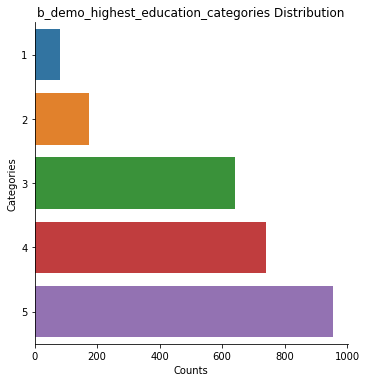

b_race_ethnicity_categories: 2592 rows


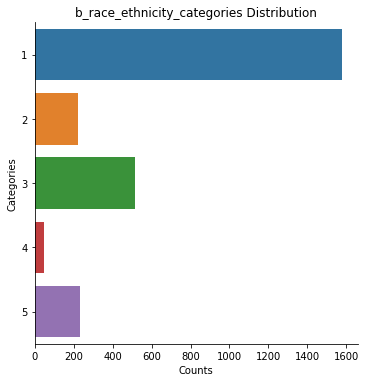

b_rel_family_id: 2592 rows
b_sex: 2592 rows


/home/sage/anaconda3/envs/bpt/lib/python3.9/site-packages/BPt/dataset/helpers.py:167: UserWarning: Skipping plot: b_rel_family_id as >= categories!
  warnings.warn(as_str)


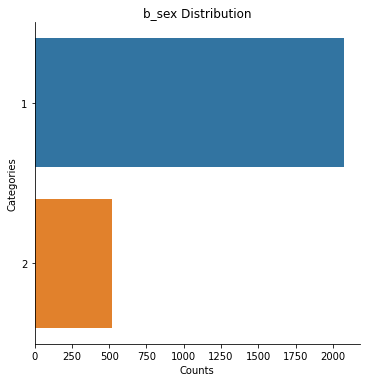

y2_mri_info_deviceserialnumber: 2592 rows


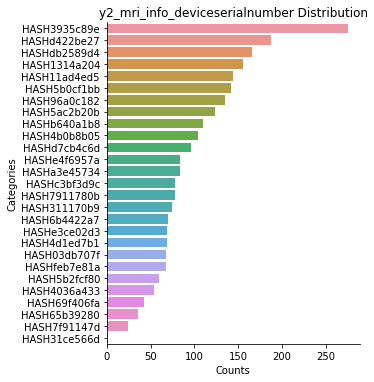

In [7]:
data = data.ordinalize([cat_covars, 'b_rel_family_id'])

# Then plot just the categorical variables
data.plot(scope='category', subjects='all', decode_values=True)

Let's plot the target variables as well.

b_bmi: 2592 rows


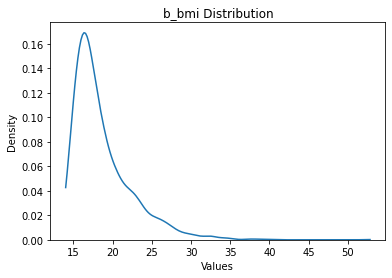

bmi_diff: 2592 rows


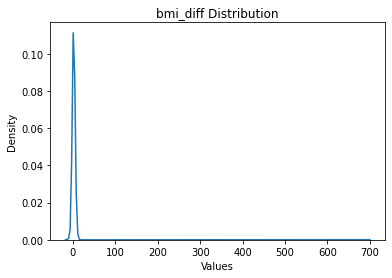

y2_bmi: 2592 rows


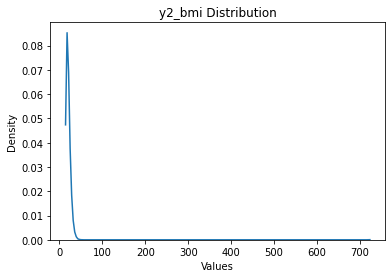

In [8]:
data.plot('target')

Okay, we note that there are some extreme outliers ... in bmi_diff and y2_bmi, we can drop these by dropping any data points which are father then 10 standard deviations from the mean.

In [9]:
data = data.filter_outliers_by_std(n_std=10, scope='target')
data['target'].max()

Dropped 1 Rows


b_bmi      52.82985
bmi_diff   12.04728
y2_bmi     46.93467
dtype: float64

b_bmi: 2591 rows


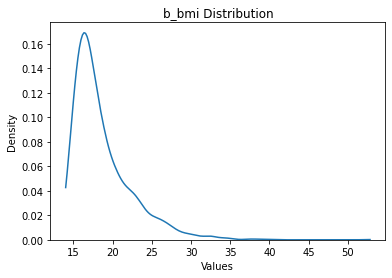

bmi_diff: 2591 rows


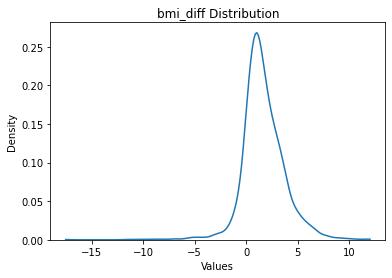

y2_bmi: 2591 rows


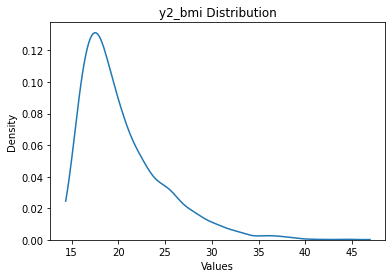

In [10]:
data.plot('target')

Okay those maximum seem much more reasonable. Let's also assume that there may be some extreme values present in the input data as well, and that these represet corrupted data that we therefore want to drop.

In [11]:
# Repeat it twice, to deal with outliers at multiple scales
data = data.filter_outliers_by_std(n_std=10, scope='float')
data = data.filter_outliers_by_std(n_std=10, scope='float')

Dropped 62 Rows
Dropped 18 Rows


Next, we consider splitting up out data with a global train and test split. This can be useful in some instances. Note that we also define a cv strategy which says to perform the train test split keeping members of the same family in the same fold.

In [12]:
# Let's say we want to keep family members in the same train or test split
cv_strategy = bp.CVStrategy(groups='b_rel_family_id')

# Test split
data = data.set_test_split(.2, random_state=5, cv_strategy=cv_strategy)
data

Performing test split on: 2511 subjects.
random_state: 5
Test split size: 0.2

Performed train/test split
Train size: 2011
Test size:  500


,b_agemos,b_demo_highest_education_categories,b_race_ethnicity_categories,b_sex,dmri_dti_full_fa_subcort_aseg_accumbens_area_lh,dmri_dti_full_fa_subcort_aseg_accumbens_area_rh,dmri_dti_full_fa_subcort_aseg_amygdala_lh,dmri_dti_full_fa_subcort_aseg_amygdala_rh,dmri_dti_full_fa_subcort_aseg_caudate_lh,dmri_dti_full_fa_subcort_aseg_caudate_rh,...,smri_vol_scs_suprateialv,smri_vol_scs_tplh,smri_vol_scs_tprh,smri_vol_scs_vedclh,smri_vol_scs_vedcrh,smri_vol_scs_wholeb,smri_vol_scs_wmhint,smri_vol_scs_wmhintlh,smri_vol_scs_wmhintrh,y2_mri_info_deviceserialnumber
0,124,1,1,0,0.00130,0.01091,-0.02198,0.00540,0.01938,0.02625,...,"5,349.45748",233.90000,-152.70000,-30.40000,-60.30000,"3,806.65748",10.50000,0,0,25
1,114,2,0,0,-0.05736,-0.06722,-0.03989,-0.03279,-0.05530,-0.05565,...,"8,612.98668",904.50000,426.10000,-106.20000,-44.60000,"8,607.68667",-68.20000,0,0,20
2,118,4,1,0,-0.01056,0.00005,0.00111,-0.01210,0.01097,-0.00400,...,"-8,676.49078",346.50000,364.40000,-153.30000,-354.10000,"-8,363.89077",-186.70000,0,0,9
3,129,2,2,0,-0.01598,0.01693,0.00801,0.00392,0.01860,-0.00437,...,"-2,028.86693",-43.20000,-108.60000,-41.80000,2.60000,-868.16693,153.40000,0,0,2
4,129,1,2,0,-0.00431,-0.00233,0.00198,0.01399,0.00302,-0.00935,...,"-10,946.83612",-428.40000,-959.60000,-367.70000,523.70000,"-13,341.83612",-116.00000,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2617,116,4,0,1,0.01832,0.01805,-0.01115,-0.01464,-0.00121,0.00636,...,"28,667.74480",222.10000,-81.30000,75.10000,-179.90000,"30,634.24480",-488.40000,0,0,9
2618,121,4,0,0,0.00590,0.01706,0.01344,-0.01547,0.05446,0.00473,...,"29,291.49896",622.10000,"1,192.90000",178.50000,-172.30000,"35,063.49896",-328.20000,0,0,6
2619,115,4,0,1,0.01052,-0.00480,-0.01075,0.00413,0.00617,-0.00796,...,"-2,472.94550",188.60000,296.00000,-80.00000,-93.40000,125.15450,-111.00000,0,0,3
2620,122,3,4,1,-0.00367,-0.02230,-0.02573,0.00112,-0.01337,0.00052,...,"-5,554.60274",92.20000,115.10000,27.90000,59.10000,"-6,407.10274",-239.70000,0,0,14


## Single Training Set Evaluation

Our Dataset is now fully prepared. We can now define and evaluate a machine learning pipeline.
We will start by considering a pipeline which a few steps, these are:

1. Winsorize just the brain data.
2. Perform Robust Scaling on any 'float' type columns, 'brain' or 'covars'
3. One Hot Encode any categorical features
4. Fit an Elastic-Net Regression with nested random hyper-parameter search

Let's use one other feature of the toolbox, that is a custom cross-validation strategy. This is the same idea that we used when defining the train-test split, but now we want it to apply both during the evaluation and during the splits made when evaluating hyper-parameters.

In [13]:
#1
w_scaler = bp.Scaler('winsorize', quantile_range=(2, 98), scope='brain')

#2
s_scaler = bp.Scaler('standard', scope='float')

#3
ohe = bp.Transformer('one hot encoder', scope='category')

#4
param_search=bp.ParamSearch('RandomSearch', n_iter=60,
                            cv=bp.CV(splits=3, cv_strategy=cv_strategy))
elastic = bp.Model('elastic', params=1,
                   param_search=param_search)

# Now we can actually defined the pipeline
pipe = bp.Pipeline(steps=[w_scaler, s_scaler, ohe, elastic])
pipe

Pipeline(steps=[Scaler(extra_params={'quantile_range': (2, 98)}, obj='winsorize', scope='brain'), Scaler(obj='standard'), Transformer(obj='one hot encoder', scope='category'), Model(obj='elastic', param_search=ParamSearch(cv=CV(cv_strategy=CVStrategy(groups='b_rel_family_id')), n_iter=60), params=1)])

Let's say we want to use a 5-fold CV to evaluate this model on just the training set. We can first define the cv, the same as for the param_search above, but this time with splits=5. 

In [14]:
cv=bp.CV(splits=5, n_repeats=1, cv_strategy=cv_strategy)
cv

CV(cv_strategy=CVStrategy(groups='b_rel_family_id'), splits=5)

And we will make a problem_spec to store some common params. In this case the random state for reproducibility of results and the number of jobs to use.

In [15]:
# Use problem spec just to store n jobs and random state
ps = bp.ProblemSpec(n_jobs=8, random_state=10)
ps

ProblemSpec(n_jobs=8, random_state=10)

Now we are ready to evaluate this pipeline, let's check an example using the function evaluate.

We will set a few specific parameters, which can be set in evaluate or fixed in problem_spec, these are:

```
target='y2_bmi'
scope='brain'
subjects='train'
```

These set:

1. Our target variable to predict as year 2 BMI.

2. Our input features as just the brain features (i.e., not the co-variates)

3. Only use as our subjects the train data



In [16]:
evaluator = bp.evaluate(pipeline=pipe,
                        dataset=data,
                        problem_spec=ps,
                        target='y2_bmi',
                        scope='brain',
                        subjects='train', 
                        cv=cv)
evaluator

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'explained_variance': 0.021253554418295285, 'neg_mean_squared_error': -19.97986420907407}
std_scores = {'explained_variance': 0.011864902647698555, 'neg_mean_squared_error': 1.657340479412642}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_indices', 'val_indices', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_']

Avaliable Methods: ['get_preds_dfs', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=8, problem_type='regression', random_state=10, scope='brain', scorer={'explained_variance': make_scorer(explained_variance_score), 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)}, subjects='train', target='y2_bmi')

## How to employ Test Set?

Next, we will discuss briefly two methods of evaluating on the test set.

1. There is a notion in some of the literature that the test set should be used to evaluate an existing estimator. In this case, that would consist of selecting from the 5 trained models we evaluated on the train set, and testing the one which performed best.

2. On the otherhand, we could instead re-train an estimator on the full training set and then test that on the test set. This is actually the reccomended strategy, but its still worth comparing both below.

Let's first do strategy 1.

In [17]:
# Get best model
best_model_ind = np.argmax(evaluator.scores['explained_variance'])
best_model = evaluator.estimators[best_model_ind]

# Get the correct test data - setting the problem spec
# as the problem spec saved when running this evaluator
X_test, y_test = data.get_Xy(problem_spec=evaluator.ps,
                             subjects='test')

# Score
score = best_model.score(X_test, y_test)
print(score)

0.019468179192349444


Next, lets compare that with re-training our model on the full training set, then testing. 

In [18]:
evaluator = bp.evaluate(pipeline=pipe,
                        dataset=data,
                        problem_spec=ps,
                        target='y2_bmi', 
                        scope='brain',
                        subjects='all',
                        cv='test')

evaluator

Folds:   0%|          | 0/1 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'explained_variance': 0.020264832058070947, 'neg_mean_squared_error': -17.06958371478156}
std_scores = {'explained_variance': 0.0, 'neg_mean_squared_error': 0.0}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_indices', 'val_indices', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_']

Avaliable Methods: ['get_preds_dfs', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=8, problem_type='regression', random_state=10, scope='brain', scorer={'explained_variance': make_scorer(explained_variance_score), 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)}, target='y2_bmi')

We can see that the results difer, though not hugely. One explanation is that at these sample sizes we still get boosts in performance from sample size, which means we expect our final model trained on the full and larger training set to do better. Another contributing factor is that by selecting from the 5-folds the model which does 'best' we may actually be choosing an overfit model which happened to do better on its corresponding validation set. We therefore reccomend the latter strategy.

In fact, we can formalize this intution, and test it on just the training set. We can do this because really the first method is just a type of meta-estimator. What it does is just in an internal nesting step, trains five models and selects the best one. We can formalize this as a custom model and compare it below.

We will also change the pipeline being compared a little bit for simplicity, replacing the elastic net we made via BPt with the ElasticNetCV object from scikit-learn.

In [19]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import ElasticNetCV
from sklearn.base import BaseEstimator

class BestOfModel(BaseEstimator):
    
    def __init__(self, estimator, cv=5):
        
        self.estimator = estimator
        self.cv = cv
        
    def fit(self, X, y):
        
        scores = cross_validate(self.estimator, X, y, cv=self.cv,
                                return_estimator=True)
        
        best_ind = np.argmax(scores['test_score'])
        self.estimator_ = scores['estimator'][best_ind]
        
    def predict(self, X):
        
        return self.estimator_.predict(X)


# The new elastic net cv to use
new_elastic = ElasticNetCV()

# The best of model
best_of_model = bp.Model(
    BestOfModel(estimator=new_elastic, cv=5))

# The static model
static_model = bp.Model(new_elastic)

# Use the same initial steps as before, but now with the best of model and the static models
best_of_pipe = bp.Pipeline(steps=[w_scaler, s_scaler, ohe, best_of_model])
static_pipe = bp.Pipeline(steps=[w_scaler, s_scaler, ohe, static_model])

Let's try the best of model first, evaluating it on the training set with 5-fold CV.

Note: This is going to be a bit slow as each time a model is trained in one of the 5-folds it needs to internally train 5 models. So it should take roughly 5x longer to evaluate then it's static counterpart.

In [20]:
evaluator = bp.evaluate(pipeline=best_of_pipe,
                        dataset=data,
                        problem_spec=ps,
                        target='y2_bmi', 
                        scope='brain', 
                        subjects='train', 
                        cv=cv)

evaluator

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'explained_variance': 0.011890555452472706, 'neg_mean_squared_error': -20.18717309468044}
std_scores = {'explained_variance': 0.007451431461277308, 'neg_mean_squared_error': 1.7376889033665959}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_indices', 'val_indices', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores']

Avaliable Methods: ['get_preds_dfs', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=8, problem_type='regression', random_state=10, scope='brain', scorer={'explained_variance': make_scorer(explained_variance_score), 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)}, subjects='train', target='y2_bmi')

Next, let's run its corresponding 'static' counterpart.

In [21]:
evaluator = bp.evaluate(pipeline=static_pipe,
                        dataset=data,
                        problem_spec=ps,
                        target='y2_bmi', 
                        scope='brain', 
                        subjects='train',
                        cv=cv)

evaluator

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'explained_variance': 0.016566885756014837, 'neg_mean_squared_error': -20.079838071255505}
std_scores = {'explained_variance': 0.008471508641454718, 'neg_mean_squared_error': 1.680294535454177}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_indices', 'val_indices', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_']

Avaliable Methods: ['get_preds_dfs', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=8, problem_type='regression', random_state=10, scope='brain', scorer={'explained_variance': make_scorer(explained_variance_score), 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)}, subjects='train', target='y2_bmi')

## Using the LinearResidualizer

BPt has an object in the extensions library designed for performing properly nested residualization on input features. This is sometimes used in the literature, though the merit of this approach is still unclear.

In [22]:
# We can import this object from extensions as
from BPt.extensions import LinearResidualizer

In [23]:
# We can make the object itself first, residualizing for time_diff
resid = LinearResidualizer(to_resid_df=data[['time_diff']])
resid

LinearResidualizer(to_resid_df=    time_diff
0   25       
..  ..       

[2511 rows x 1 columns])

This object is itself a sklearn compliant transformer. We can use it in the pipeline by setting it as a scaler. Note that we set scope='brain', as we only want to residualize the brain variables.

In [24]:
resid_scaler = bp.Scaler(resid, scope='brain')
resid_scaler 

Scaler(obj=LinearResidualizer(to_resid_df=      time_diff
0            25
1            24
2            24
3            23
4            26
...         ...
2617         24
2618         23
2619         21
2620         24
2621         22

[2511 rows x 1 columns]), scope='brain')

Now let's integrate it with our other pipeline.

In [25]:
# Original steps
print('original steps:', pipe.steps)

# New steps
resid_pipe = pipe.copy()
resid_pipe.steps = resid_pipe.steps[:-1] + [resid_scaler] + [resid_pipe.steps[-1]]

print('resid steps:', resid_pipe.steps)

original steps: [Scaler(extra_params={'quantile_range': (2, 98)}, obj='winsorize', scope='brain'), Scaler(obj='standard'), Transformer(obj='one hot encoder', scope='category'), Model(obj='elastic', param_search=ParamSearch(cv=CV(cv_strategy=CVStrategy(groups='b_rel_family_id')), n_iter=60), params=1)]
resid steps: [Scaler(extra_params={'quantile_range': (2, 98)}, obj='winsorize', scope='brain'), Scaler(obj='standard'), Transformer(obj='one hot encoder', scope='category'), Scaler(obj=LinearResidualizer(to_resid_df=      time_diff
0            25
1            24
2            24
3            23
4            26
...         ...
2617         24
2618         23
2619         21
2620         24
2621         22

[2511 rows x 1 columns]), scope='brain'), Model(obj='elastic', param_search=ParamSearch(cv=CV(cv_strategy=CVStrategy(groups='b_rel_family_id')), n_iter=60), params=1)]


In [26]:
# Same evaluate as before
evaluator = bp.evaluate(pipeline=resid_pipe,
                        dataset=data,
                        problem_spec=ps,
                        target='y2_bmi', 
                        scope='brain',
                        subjects='all',
                        cv='test')

evaluator

Folds:   0%|          | 0/1 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'explained_variance': 0.02062763589724137, 'neg_mean_squared_error': -17.06324050542408}
std_scores = {'explained_variance': 0.0, 'neg_mean_squared_error': 0.0}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_indices', 'val_indices', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_']

Avaliable Methods: ['get_preds_dfs', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=8, problem_type='regression', random_state=10, scope='brain', scorer={'explained_variance': make_scorer(explained_variance_score), 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)}, target='y2_bmi')

## Compare & Evaluate

Let's now try out a newer feature the input class Compare. We can also use another parameter Option to make the results easier to work with after. Let's define two different things to Compare here first.

In [27]:
# Two choices of Pipeline, compare or not.
compare_pipes = bp.Compare([bp.Option(pipe, name='base'),
                            bp.Option(resid_pipe, name='resid')])

# No need to set name's here since the value itself is a good name
compare_scopes = bp.Compare(['covars', 'brain', 'all'])

In [28]:
evaluators = bp.evaluate(pipeline=compare_pipes, # So choice of pipeline and scope are now Compare
                         scope=compare_scopes,
                         dataset=data,
                         problem_spec=ps,
                         target='y2_bmi', # Note we still have y2_bmi fixed as the target
                         subjects='train', # and train subjects only
                         cv=cv, # CV still out custom CV.
                         eval_verbose=0)

Compare:   0%|          | 0/6 [00:00<?, ?it/s]

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

In [29]:
# Look at a summary of the results - note this option is only avaliable after a call to evaluate with
# Compare's has been made!
evaluators.summary()

mean_scores_explained_variance  \
pipeline scope                                    
base     covars                         0.08750   
         brain                          0.02125   
         all                            0.06004   
resid    covars                         0.08750   
         brain                          0.02201   
         all                            0.06033   

                 mean_scores_neg_mean_squared_error  \
pipeline scope                                        
base     covars                           -18.63043   
         brain                            -19.97986   
         all                              -19.18665   
resid    covars                           -18.63043   
         brain                            -19.96367   
         all                              -19.17940   

                 std_scores_explained_variance  \
pipeline scope                                   
base     covars                        0.02043   
         brain                         0.01186   
         all                           0.01530   
resid    covars                        0.02043   
         brain                         0.01203   
         all                           0.01569   

                 std_scores_neg_mean_squared_error  mean_timing_fit  \
pipeline scope                                                        
base     covars                            1.60705          2.36674   
         brain                             1.65734          8.67881   
         all                               1.59740          8.37871   
resid    covars                            1.60705          2.84961   
         brain                             1.65617          8.29963   
         all                               1.59423          8.36900   

                 mean_timing_score  
pipeline scope                      
base     covars            0.03439  
         brain             0.02694  
         all               0.04497  
resid    covars            0.03162  
         brain             0.08293  
         all               0.06644

We can also try another method avaliable which will run a pairwise model ttest comparison between all options

In [30]:
evaluators.pairwise_t_stats(metric='explained_variance')

,pipeline (1),scope (1),pipeline (2),scope (2),t_stat,p_val
0,base,covars,base,brain,6.59395,0.02055
1,base,covars,base,all,4.04477,0.11657
2,base,covars,resid,brain,6.63327,0.02010
3,base,covars,resid,all,3.99660,0.12132
4,base,brain,base,all,-7.60785,0.01202
5,base,brain,resid,covars,-6.59395,0.02055
6,base,brain,resid,brain,-2.41288,0.54995
7,base,brain,resid,all,-7.34386,0.01373
8,base,all,resid,covars,-4.04477,0.11657
9,base,all,resid,brain,7.91573,0.01034


We can also explicitly compare two evaluators

In [31]:
e1 = evaluators['pipeline=base, scope=covars']
e2 = evaluators['pipeline=base, scope=brain']

# Look at function docstring
print('       ', e1.compare.__doc__)
print()

e1.compare(e2)

        This method is designed to perform a statistical comparison
        between the results from the evaluation stored in this object
        and another instance of :class:`BPtEvaluator`. The statistics
        produced here are explained in:
        https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html

        .. note::
            In the case that the sizes of the training and validation sets
            at each fold vary dramatically, it is unclear if this
            statistics are still valid.
            In that case, the mean train size and mean validation sizes
            are employed when computing statistics.

        Parameters
        ------------
        other : :class:`BPtEvaluator`
            Another instance of :class:`BPtEvaluator` in which
            to compare which. The cross-validation used
            should be the same in both instances, otherwise
            statistics will not be generated.

        rope_interval : l

,mean_diff,std_diff,t_stat,p_val,better_prob,worse_prob,rope_prob
neg_mean_squared_error,1.34943,-0.05030,6.16829,0.00175,0.99820,0.00171,0.00010
explained_variance,0.06625,0.00856,6.59395,0.00137,0.99750,0.00081,0.00169


Okay so it looks like it ran all the different combinations, but how do we look at each indivudal evaluator / the full results?? There are few different ways to index the object storing the different evaluators, but its essentially a dictionary. We can index one run as follows:

In [32]:
evaluators['pipeline=base, scope=covars']

BPtEvaluator
------------
mean_scores = {'explained_variance': 0.08750025137203998, 'neg_mean_squared_error': -18.63043213787136}
std_scores = {'explained_variance': 0.0204257696433489, 'neg_mean_squared_error': 1.6070454784784487}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_indices', 'val_indices', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores']

Avaliable Methods: ['get_preds_dfs', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=8, problem_type='regression', random_state=10, scope='covars', scorer={'explained_variance': make_scorer(explained_variance_score), 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)}, subjects='train', target='y2_bmi')

In [33]:
# Note, with get_fis, if mean=True it will return
# the mean and only non-null, and non-zero features directly.
evaluators['pipeline=base, scope=covars'].get_fis(mean=True)

b_demo_highest_education_categories=1            0.24071
b_demo_highest_education_categories=2            0.45955
b_demo_highest_education_categories=3            0.26963
b_demo_highest_education_categories=4           -0.71133
b_demo_highest_education_categories=5           -1.20322
b_race_ethnicity_categories=1                   -0.72083
b_race_ethnicity_categories=2                    0.84072
b_race_ethnicity_categories=3                    0.78320
b_race_ethnicity_categories=4                   -0.27170
b_race_ethnicity_categories=5                   -0.00703
b_sex=1                                          0.01196
b_sex=2                                         -0.01194
y2_mri_info_deviceserialnumber='HASH03db707f'    0.72240
y2_mri_info_deviceserialnumber='HASH11ad4ed5'   -0.88266
y2_mri_info_deviceserialnumber='HASH1314a204'   -0.73021
y2_mri_info_deviceserialnumber='HASH3935c89e'   -0.05978
y2_mri_info_deviceserialnumber='HASH4036a433'   -0.00387
y2_mri_info_deviceserialnumber=

Warning: This doesn't mean that this mean features were selected! Remember this is the average over training 5 models, so it means that if a feature shows up it was selected at least once in one of the models!

In [34]:
# These are the different options
evaluators.keys()

dict_keys([Options(pipeline=base, scope=covars), Options(pipeline=base, scope=brain), Options(pipeline=base, scope=all), Options(pipeline=resid, scope=covars), Options(pipeline=resid, scope=brain), Options(pipeline=resid, scope=all)])

We can index multiple like this ...

In [35]:
evaluators['covars']

CompareDict({Options(pipeline=base, scope=covars): BPtEvaluator
------------
mean_scores = {'explained_variance': 0.08750025137203998, 'neg_mean_squared_error': -18.63043213787136}
std_scores = {'explained_variance': 0.0204257696433489, 'neg_mean_squared_error': 1.6070454784784487}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_indices', 'val_indices', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores']

Avaliable Methods: ['get_preds_dfs', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=8, problem_type='regression', random_state=10, scope='covars', scorer={'explained_variance': make_scorer(explained_variance_score), 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)}, subjects='train', target='y2_bmi')
, Options(pipeline=resid, scope=covars): BPtEvaluator
------------
mean_scores = {'explained_variance': 0.08750025137203998, 'neg_mean_squared_error': -18.63043213787136}
std_scores = {'explained_v

In [36]:
# Or get a summary of just this subset
evaluators['covars'].summary()

,,mean_scores_explained_variance,mean_scores_neg_mean_squared_error,std_scores_explained_variance,std_scores_neg_mean_squared_error,mean_timing_fit,mean_timing_score
pipeline,scope,,,,,,
base,covars,0.08750,-18.63043,0.02043,1.60705,2.36674,0.03439
resid,covars,0.08750,-18.63043,0.02043,1.60705,2.84961,0.03162


Note the resid_pipeline just covars and normal pipeline did the same... this is good, since they are exactly the same.

That will end this example.